# `langid.pyc` benchmark

The goal is to
1) Make sure the quality of `langid.pyc` is close to the quality of the `langid.py`.
2) Measure inference speed and compare with other libraries.

In [1]:
# pycld2 with fix for installing on Mac
# pip install git+https://github.com/tmikus/pycld2.git

In [134]:
# pip install langcodes==3.3.0 langid==1.1.6 fasttext==0.9.2 lingua-language-detector==2.0.2 scikit-learn==1.3.2 datasets==2.18.0

In [3]:
# pip install -i https://test.pypi.org/simple/ langid-pyc==0.0.7

In [189]:
# pip install pandas tqdm ipywidgets matplotlib jinja2

In [300]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

## Datasets

I've decided to choose rather new datasets

1. [LanideNN test set](https://ufal.mff.cuni.cz/tom-kocmi/lanidenn)
2. [Lingua sentences test set](https://github.com/pemistahl/lingua-py/tree/main/language-testdata/sentences)
3. [WiLI 2018 test set](https://huggingface.co/datasets/wili_2018)
4. [nordic_langid test set](https://huggingface.co/datasets/strombergnlp/nordic_langid)

All datasets will be stored in pandas DataFrame with `text` and `lang` columns

In [194]:
from enum import Enum


class Dataset(str, Enum):
    LANIDENN = "lanidenn"
    LINGUA = "lingua"
    NORDIC = "nordic"
    WILI_2018 = "wili_2018"

In [145]:
from collections import defaultdict

lanidenn_test_data = defaultdict(list)

with open("lanidenn_testset.txt") as f:
    for line in f:
        if not line.strip():
            continue
        lang, text = line.split(" ", 1)
        lanidenn_test_data["text"].append(text.strip())
        lanidenn_test_data["lang"].append(lang.strip())

In [146]:
from pathlib import Path

lingua_test_data = defaultdict(list)

for path in Path("sentences").glob("*.txt"):
    lang = path.stem
    
    with path.open() as f:
        for line in f:
            if not line.strip():
                continue
            lingua_test_data["text"].append(line.strip())
            lingua_test_data["lang"].append(lang)

In [170]:
from datasets import load_dataset

nordic_langid_test_data = load_dataset("strombergnlp/nordic_langid", '50k', split='test')
wili_2018_test_data = load_dataset("wili_2018", split='test')

Generating train split:   0%|          | 0/284231 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14960 [00:00<?, ? examples/s]

/Users/liablefish/github/langid-pyc/.venv/lib/python3.8/site-packages/datasets/load.py:1461: FutureWarning: The repository for wili_2018 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wili_2018
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/117500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/117500 [00:00<?, ? examples/s]

In [175]:
lanidenn_test_df = pd.DataFrame(lanidenn_test_data)

lingua_test_df = pd.DataFrame(lingua_test_data)

nordic_langid_test_df = (
    nordic_langid_test_data
    .to_pandas()
    .drop(columns=["id"])
    .rename(columns={"sentence": "text", "language": "lang"})
)

nordic_langid_test_df["lang"] = nordic_langid_test_df["lang"].apply(nordic_langid_test_data.features["language"].int2str)


wili_2018_test_df = (
    wili_2018_test_data
    .to_pandas()
    .rename(columns={"sentence": "text", "label": "lang"})
)

wili_2018_test_df["lang"] = wili_2018_test_df["lang"].apply(wili_2018_test_data.features["label"].int2str)

In [179]:
DATASET_TO_DF = {
    Dataset.LANIDENN: lanidenn_test_df,
    Dataset.LINGUA: lingua_test_df,
    Dataset.NORDIC: nordic_langid_test_df,
    Dataset.WILI_2018: wili_2018_test_df,
}

#### Unify language tags

Datasets and identifiers have languages specified in possibly different formats. Let's unify them all using BCP47 tags with [langcodes](https://pypi.org/project/langcodes/)

In [178]:
from langcodes import LanguageTagError, standardize_tag


def to_standard_tag(lang: str) -> str:
    try:
        return standardize_tag(lang)
    except LanguageTagError:
        return "und"

In [180]:
for dataset in Dataset:
    DATASET_TO_DF[dataset]["y_true"] = DATASET_TO_DF[dataset]["lang"].apply(to_standard_tag)

In [250]:
dataset_stats = {}

for dataset in Dataset:
    df = DATASET_TO_DF[dataset]
    dataset_stats[dataset.value] = {
        "n_texts": df.shape[0],
        "n_unique_langs": df.y_true.nunique(),
        "mean_text_len": df.text.str.len().mean(),
        "std_text_len": df.text.str.len().std()
    }

display(
    pd.DataFrame(dataset_stats)
    .T
    .style
    .format({"n_texts": "{:.0f}", "n_unique_langs": "{:.0f}"})
    .highlight_min(color="yellow")
    .highlight_max(color="green")
)

,n_texts,n_unique_langs,mean_text_len,std_text_len
lanidenn,13100,131,137.326718,176.357921
lingua,74141,75,105.229239,54.332949
nordic,14960,6,107.197928,66.834498
wili_2018,117500,235,372.764187,812.990350


## Identifiers

Apart from our target `langid.pyc`, we'll use the most common language identifers
1. [langid.py](https://github.com/saffsd/langid.py)
2. [fasttext](https://fasttext.cc/docs/en/language-identification.html) (large and small versions)
3. [pycld2](https://github.com/aboSamoor/pycld2)
4. [lingua-py](https://github.com/pemistahl/lingua-py) (default and low accuracy modes)

In [120]:
class Identifier(str, Enum):
    LANGID_PY = "langid_py"
    LANGID_PYC = "langid_pyc"
    FASTTEXT = "fasttext"
    FASTTEXT_SMALL = "fasttext_small"
    PYCLD2 = "pycld2"
    LINGUA = "lingua"
    LINGUA_LOW_ACCURACY = "lingua_low_accuracy"



Set up all identifiers

In [193]:
from typing import Tuple
import langid
import langid_pyc
import pycld2
import fasttext
import requests

from pathlib import Path
from langid import langid

from lingua import LanguageDetectorBuilder, Language as LinguaLanguage


LANGID_PY_DETECTOR = langid.LanguageIdentifier.from_modelstring(langid.model, norm_probs=True)

FASSTEXT_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
FASTTEXT_MODEL_PATH = Path("fasttext_model.bin")
FASSTEXT_SMALL_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz"
FASSTEXT_SMALL_MODEL_PATH = Path("fasttext_model_small.bin")

with Path(FASTTEXT_MODEL_PATH).open("wb") as f:
    f.write(requests.get(FASSTEXT_MODEL_URL).content)

with Path(FASSTEXT_SMALL_MODEL_PATH).open("wb") as f:
    f.write(requests.get(FASSTEXT_SMALL_MODEL_URL).content)

FASTTEXT_DETECTOR = fasttext.load_model(str(FASTTEXT_MODEL_PATH))
FASTTEXT_SMALL_DETECTOR = fasttext.load_model(str(FASSTEXT_SMALL_MODEL_PATH))


LINGUA_DETECTOR = (
    LanguageDetectorBuilder
    .from_all_languages()
    .with_preloaded_language_models()
    .build()
)

LINGUA_DETECTOR_LOW_ACCURACY = (
    LanguageDetectorBuilder
    .from_all_languages()
    .with_preloaded_language_models()
    .with_low_accuracy_mode()
    .build()
)


def pycld2_detect(text: str) -> Tuple[str, float]:
    try:
        res = pycld2.detect(text)
    except pycld2.error as e:
        res = (False,
            0,
            (('Unknown', 'un', 0, 0.0),
            ('Unknown', 'un', 0, 0.0),
            ('Unknown', 'un', 0, 0.0)),
        )

    return res[2][0][1], res[2][0][2]

def fasttext_predict(text: str) -> Tuple[str, float]:
    [label], [score] = FASTTEXT_DETECTOR.predict(text.replace("\n", ""))
    return label[len("__label__"):], score

def fasttext_small_predict(text: str) -> Tuple[str, float]:
    [label], [score] = FASTTEXT_SMALL_DETECTOR.predict(text.replace("\n", ""))
    return label[len("__label__"):], score

def lingua_detect(text: str) -> Tuple[str, float]:
    confidence_value = LINGUA_DETECTOR.compute_language_confidence_values(text)[0]
    score = confidence_value.value
    label = confidence_value.language.iso_code_639_3.name
    return label, score

def lingua_low_accuracy_detect(text: str) -> Tuple[str, float]:
    confidence_value = LINGUA_DETECTOR_LOW_ACCURACY.compute_language_confidence_values(text)[0]
    score = confidence_value.value
    label = confidence_value.language.iso_code_639_3.name
    return label, score


In [195]:
IDENTIFIER_TO_RUNNABLE = {
    Identifier.LANGID_PY: LANGID_PY_DETECTOR.classify,
    Identifier.LANGID_PYC: langid_pyc.classify,
    Identifier.FASTTEXT: fasttext_predict,
    Identifier.FASTTEXT_SMALL: fasttext_small_predict,
    Identifier.PYCLD2: pycld2_detect,
    Identifier.LINGUA: lingua_detect,
    Identifier.LINGUA_LOW_ACCURACY: lingua_low_accuracy_detect,
}

In [196]:
IDENTIFIER_TO_SUPPORTED_LANGUAGE_TAGS = {
    Identifier.LANGID_PY: LANGID_PY_DETECTOR.nb_classes,
    Identifier.LANGID_PYC: langid_pyc.nb_classes(),
    Identifier.FASTTEXT: [label[len("__label__"):] for label in FASTTEXT_DETECTOR.get_labels()],
    Identifier.FASTTEXT_SMALL: [label[len("__label__"):] for label in FASTTEXT_SMALL_DETECTOR.get_labels()],
    Identifier.PYCLD2: [code for lang, code in pycld2.LANGUAGES if lang in pycld2.DETECTED_LANGUAGES],
    Identifier.LINGUA: [lang.iso_code_639_3.name for lang in LinguaLanguage.all()],
    Identifier.LINGUA_LOW_ACCURACY: [lang.iso_code_639_3.name for lang in LinguaLanguage.all()],
}

for key, value in IDENTIFIER_TO_SUPPORTED_LANGUAGE_TAGS.items():
    IDENTIFIER_TO_SUPPORTED_LANGUAGE_TAGS[key] = frozenset(to_standard_tag(lang) for lang in value)

SUPPORTED_LANGUAGE_TAGS = frozenset.intersection(*IDENTIFIER_TO_SUPPORTED_LANGUAGE_TAGS.values())

In [197]:
len(SUPPORTED_LANGUAGE_TAGS)

64

#### Identifers stats

In [249]:
identifiers_stats =  {}

for identifier in Identifier:
    identifiers_stats[identifier.value] ={
        "n_langs": len(IDENTIFIER_TO_SUPPORTED_LANGUAGE_TAGS[identifier])
    }

display(
    pd.DataFrame(identifiers_stats)
    .T
    .style
    .highlight_min(color="yellow")
    .highlight_max(color="green")
)

,n_langs
langid_py,97
langid_pyc,97
fasttext,176
fasttext_small,176
pycld2,165
lingua,75
lingua_low_accuracy,75


## Let's run

We'll track time for inference on each text to get duration excluding time iterating over the array of texts

In [208]:
import time

def _run(
    identifier,
    texts,
):
    total_elapsed = time.perf_counter()

    for text in texts:
        start = time.perf_counter()
        lang, score = identifier(text)
        elapsed = time.perf_counter() - start

        yield {
            'lang_pred': lang,
            'score': score,
            'elapsed': elapsed,
            'total_elapsed': time.perf_counter() - total_elapsed
        }

def run_on_dataset(identifier: Identifier, dataset: Dataset):
    df = DATASET_TO_DF[dataset]

    preds = (
        tqdm(
            _run(IDENTIFIER_TO_RUNNABLE[identifier], df.text.values),
            desc=f"Running {identifier} on {dataset}",
            total=df.shape[0],
        )
    )
    return list(preds)


In [209]:
for dataset in Dataset:
    for identifier in Identifier:
        DATASET_TO_DF[dataset][f"{identifier}_pred"] = run_on_dataset(identifier, dataset)

Running langid_py on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running langid_pyc on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running fasttext on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running fasttext_small on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running pycld2 on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running lingua on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running lingua_low_accuracy on lanidenn:   0%|          | 0/13100 [00:00<?, ?it/s]

Running langid_py on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running langid_pyc on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running fasttext on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running fasttext_small on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running pycld2 on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running lingua on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running lingua_low_accuracy on lingua:   0%|          | 0/74141 [00:00<?, ?it/s]

Running langid_py on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running langid_pyc on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running fasttext on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running fasttext_small on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running pycld2 on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running lingua on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running lingua_low_accuracy on nordic:   0%|          | 0/14960 [00:00<?, ?it/s]

Running langid_py on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running langid_pyc on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running fasttext on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running fasttext_small on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running pycld2 on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running lingua on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

Running lingua_low_accuracy on wili_2018:   0%|          | 0/117500 [00:00<?, ?it/s]

#### Inference speed stats

In [251]:
inference_speed_stats = defaultdict(dict)

for dataset in Dataset:
    df = DATASET_TO_DF[dataset]
    for identifier in Identifier:
        pred_key = f"{identifier}_pred"
        elapsed = df[pred_key].apply(lambda pred: pred["elapsed"])
        inference_speed_stats[dataset.value][identifier.value] = {
            "total_elapsed": df[pred_key].iloc[-1]["total_elapsed"],
            "elapsed_sum": elapsed.sum(),
            "elapsed_mean": elapsed.mean(),
            "elapsed_std": elapsed.std(),
            "throughput": df.shape[0] / elapsed.sum(),
        }

for dataset in Dataset:
    display(
        pd.DataFrame(inference_speed_stats[dataset])
        .T
        .style
        .set_caption(dataset.value)
        .format({"throughput": "{:.2f}", "total_elapsed": "{:.4f}", "elapsed_sum": "{:.4f}"})
        .highlight_min(subset=["total_elapsed", "elapsed_sum", "elapsed_mean", "elapsed_std"], color="yellow")
        .highlight_max(subset=["throughput"], color="green")
    )

,total_elapsed,elapsed_sum,elapsed_mean,elapsed_std,throughput
langid_py,21.5182,21.1745,0.001616,0.002087,618.67
langid_pyc,0.1115,0.0924,0.000007,0.000014,141826.74
fasttext,0.2740,0.2589,0.000020,0.000028,50602.04
fasttext_small,0.3827,0.3727,0.000028,0.000034,35152.00
pycld2,0.1205,0.1121,0.000009,0.000011,116905.94
lingua,5.8008,5.7515,0.000439,0.000357,2277.67
lingua_low_accuracy,2.6139,2.5896,0.000198,0.000205,5058.62


,total_elapsed,elapsed_sum,elapsed_mean,elapsed_std,throughput
langid_py,129.1927,127.3772,0.001718,0.002158,582.06
langid_pyc,0.6173,0.5465,0.000007,0.000112,135656.91
fasttext,1.1707,1.1224,0.000015,0.000007,66053.01
fasttext_small,1.5923,1.5412,0.000021,0.000010,48104.91
pycld2,0.5469,0.5033,0.000007,0.000007,147297.84
lingua,32.4454,32.2270,0.000435,0.000351,2300.58
lingua_low_accuracy,12.8805,12.7490,0.000172,0.000115,5815.43


,total_elapsed,elapsed_sum,elapsed_mean,elapsed_std,throughput
langid_py,24.5776,24.3259,0.001626,0.002274,614.98
langid_pyc,0.1572,0.1314,0.000009,0.000027,113841.30
fasttext,0.2580,0.2420,0.000016,0.000040,61812.11
fasttext_small,0.2793,0.2692,0.000018,0.000009,55569.21
pycld2,0.1205,0.1113,0.000007,0.000007,134374.03
lingua,8.4705,8.3978,0.000561,0.000324,1781.42
lingua_low_accuracy,3.5676,3.5299,0.000236,0.000135,4238.07


,total_elapsed,elapsed_sum,elapsed_mean,elapsed_std,throughput
langid_py,224.9927,222.0286,0.001890,0.002261,529.21
langid_pyc,1.7365,1.6225,0.000014,0.000077,72419.92
fasttext,5.7672,5.6486,0.000048,0.000097,20801.49
fasttext_small,7.6737,7.5514,0.000064,0.000160,15560.01
pycld2,2.6723,2.5762,0.000022,0.000045,45609.91
lingua,70.6065,70.0510,0.000596,0.000495,1677.35
lingua_low_accuracy,61.7045,61.2277,0.000521,0.000463,1919.07


In [304]:
np.mean(
    [
        values[Identifier.LANGID_PYC]["throughput"] / values[Identifier.LANGID_PY]["throughput"]
        for values in inference_speed_stats.values()
    ]
)

196.06683714432594

We see that `langid_pyc` is ~200 times faster than `langid_py` and performs on pair with `pycld2`.

#### Classification metrics

For simplicity, we'll calculate metris only on intersection of supported languages (taking into account standartized language tags!)

In [258]:
from sklearn.metrics import classification_report

classification_metrics = defaultdict(dict)

for dataset in tqdm(Dataset):
    df = DATASET_TO_DF[dataset]
    for identifier in Identifier:
        pred_key = f"{identifier}_pred"
        lang_pred = df[pred_key].apply(lambda pred: pred["lang_pred"])

        y_pred = lang_pred.apply(to_standard_tag)
        metrics = classification_report(
            y_true=df["y_true"],
            y_pred=y_pred,
            labels=sorted(SUPPORTED_LANGUAGE_TAGS & set(df["y_true"])),
            output_dict=True,
        )
        
        classification_metrics[dataset.value][identifier.value] = {}
        for avg in ["micro", "macro", "weighted"]:
            for metric_name in ["precision", "recall", "f1-score"]:
                classification_metrics[dataset.value][identifier.value][f"{avg}_{metric_name}"] = (
                    metrics[f"{avg} avg"][metric_name]
                )


  0%|          | 0/4 [00:00<?, ?it/s]

In [259]:
def _bold_macro_f1(row):
    if row.name == "macro_f1-score":
        return ['font-weight: bold' for _ in row]
    return ['' for _ in row]

for dataset in Dataset:
    display(
        pd.DataFrame(classification_metrics[dataset])
        .style
        .set_caption(dataset.value)
        .format("{:.3f}")
        .apply(_bold_macro_f1, axis=1)
        .highlight_min(color="yellow", axis=1)
        .highlight_max(color="green", axis=1)
    )

,langid_py,langid_pyc,fasttext,fasttext_small,pycld2,lingua,lingua_low_accuracy
micro_precision,0.546,0.546,0.677,0.626,0.844,0.513,0.491
micro_recall,0.909,0.909,0.940,0.912,0.909,0.956,0.917
micro_f1-score,0.682,0.682,0.787,0.742,0.875,0.668,0.640
macro_precision,0.671,0.671,0.792,0.754,0.892,0.652,0.623
macro_recall,0.909,0.909,0.940,0.912,0.909,0.956,0.917
macro_f1-score,0.744,0.744,0.837,0.797,0.889,0.744,0.713
weighted_precision,0.671,0.671,0.792,0.754,0.892,0.652,0.623
weighted_recall,0.909,0.909,0.940,0.912,0.909,0.956,0.917
weighted_f1-score,0.744,0.744,0.837,0.797,0.889,0.744,0.713


,langid_py,langid_pyc,fasttext,fasttext_small,pycld2,lingua,lingua_low_accuracy
micro_precision,0.861,0.861,0.832,0.813,0.960,0.956,0.931
micro_recall,0.924,0.924,0.936,0.918,0.935,0.959,0.931
micro_f1-score,0.891,0.891,0.881,0.862,0.947,0.958,0.931
macro_precision,0.891,0.891,0.885,0.858,0.963,0.960,0.935
macro_recall,0.925,0.925,0.937,0.919,0.936,0.959,0.932
macro_f1-score,0.897,0.897,0.895,0.872,0.945,0.957,0.931
weighted_precision,0.890,0.890,0.883,0.856,0.963,0.959,0.934
weighted_recall,0.924,0.924,0.936,0.918,0.935,0.959,0.931
weighted_f1-score,0.896,0.896,0.894,0.871,0.944,0.956,0.930


,langid_py,langid_pyc,fasttext,fasttext_small,pycld2,lingua,lingua_low_accuracy
micro_precision,0.842,0.842,0.782,0.768,0.953,0.745,0.698
micro_recall,0.850,0.850,0.863,0.840,0.878,0.914,0.810
micro_f1-score,0.846,0.846,0.820,0.802,0.914,0.821,0.750
macro_precision,0.872,0.872,0.825,0.817,0.957,0.787,0.736
macro_recall,0.850,0.850,0.863,0.840,0.878,0.913,0.809
macro_f1-score,0.848,0.848,0.827,0.808,0.913,0.833,0.753
weighted_precision,0.871,0.871,0.825,0.816,0.957,0.786,0.735
weighted_recall,0.850,0.850,0.863,0.840,0.878,0.914,0.810
weighted_f1-score,0.848,0.848,0.826,0.808,0.913,0.833,0.753


,langid_py,langid_pyc,fasttext,fasttext_small,pycld2,lingua,lingua_low_accuracy
micro_precision,0.341,0.341,0.394,0.372,0.576,0.294,0.294
micro_recall,0.940,0.940,0.950,0.946,0.940,0.951,0.948
micro_f1-score,0.500,0.500,0.557,0.534,0.714,0.450,0.449
macro_precision,0.529,0.529,0.637,0.607,0.717,0.484,0.482
macro_recall,0.940,0.940,0.950,0.946,0.940,0.951,0.948
macro_f1-score,0.627,0.627,0.708,0.680,0.787,0.590,0.589
weighted_precision,0.529,0.529,0.637,0.607,0.717,0.484,0.482
weighted_recall,0.940,0.940,0.950,0.946,0.940,0.951,0.948
weighted_f1-score,0.627,0.627,0.708,0.680,0.787,0.590,0.589


We see that `langid_pyc` metrics equal to `langid_py` ones as expected. The best identifier on average is `pycld2`.

The scores for `langid_pyc` and `langid_py` are also the same

In [307]:
for dataset in Dataset:
    df = DATASET_TO_DF[dataset]
    assert np.allclose(
        df[f"{Identifier.LANGID_PY}_pred"].apply(lambda pred: pred["score"]).values,
        df[f"{Identifier.LANGID_PYC}_pred"].apply(lambda pred: pred["score"]).values,
    )

print("All correct!")

All correct!


#### Effect of text length

One might notice that speed wise `langid_pyc` outperforms `pycld2` on datasets with longer texts (`wili_2018` and `lanidenn`). 

Let's see how each identifier performs on texts of different legnths.

In [268]:
longest_text = ""
longest_text_lang = "und"
longest_text_len = 0

for dataset in Dataset:
    df = DATASET_TO_DF[dataset]
    dataset_longest_text = df[df.text.str.len() == df.text.str.len().max()].text.iloc[0]
    dataset_longest_text_lang = df[df.text == dataset_longest_text].y_true.iloc[0]

    if len(dataset_longest_text) > longest_text_len:
        longest_text_len = len(dataset_longest_text)
        longest_text = dataset_longest_text
        longest_text_lang = dataset_longest_text_lang

In [308]:
len(longest_text), longest_text_lang

(195402, 'bo')

In [311]:
longest_text[:100]

'འཁོར་བའི་བྱ་བཞག་སྙིང་པོ་མེད་པར་དགོངས། །སྙིང་རྗེ་ཆེན་པོས་གཞན་དོན་འབའ་ཞིག་གཉེར། །སྲིད་ཞིར་མ་ཞེན་ཐེག་ཆེ'

In [285]:
from tqdm.auto import trange


identifier_to_preds = defaultdict(list)
identifier_to_times = defaultdict(list)


for identifier in Identifier:
    for n in trange(0, len(longest_text), 100, desc=f"Runing {identifier}"):
        start = time.perf_counter()
        preds = IDENTIFIER_TO_RUNNABLE[identifier](longest_text[:n])
        identifier_to_times[identifier].append(time.perf_counter() - start)        
        identifier_to_preds[identifier].append(preds)

Runing langid_py:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing langid_pyc:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing fasttext:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing fasttext_small:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing pycld2:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing lingua:   0%|          | 0/1955 [00:00<?, ?it/s]

Runing lingua_low_accuracy:   0%|          | 0/1955 [00:00<?, ?it/s]

[]

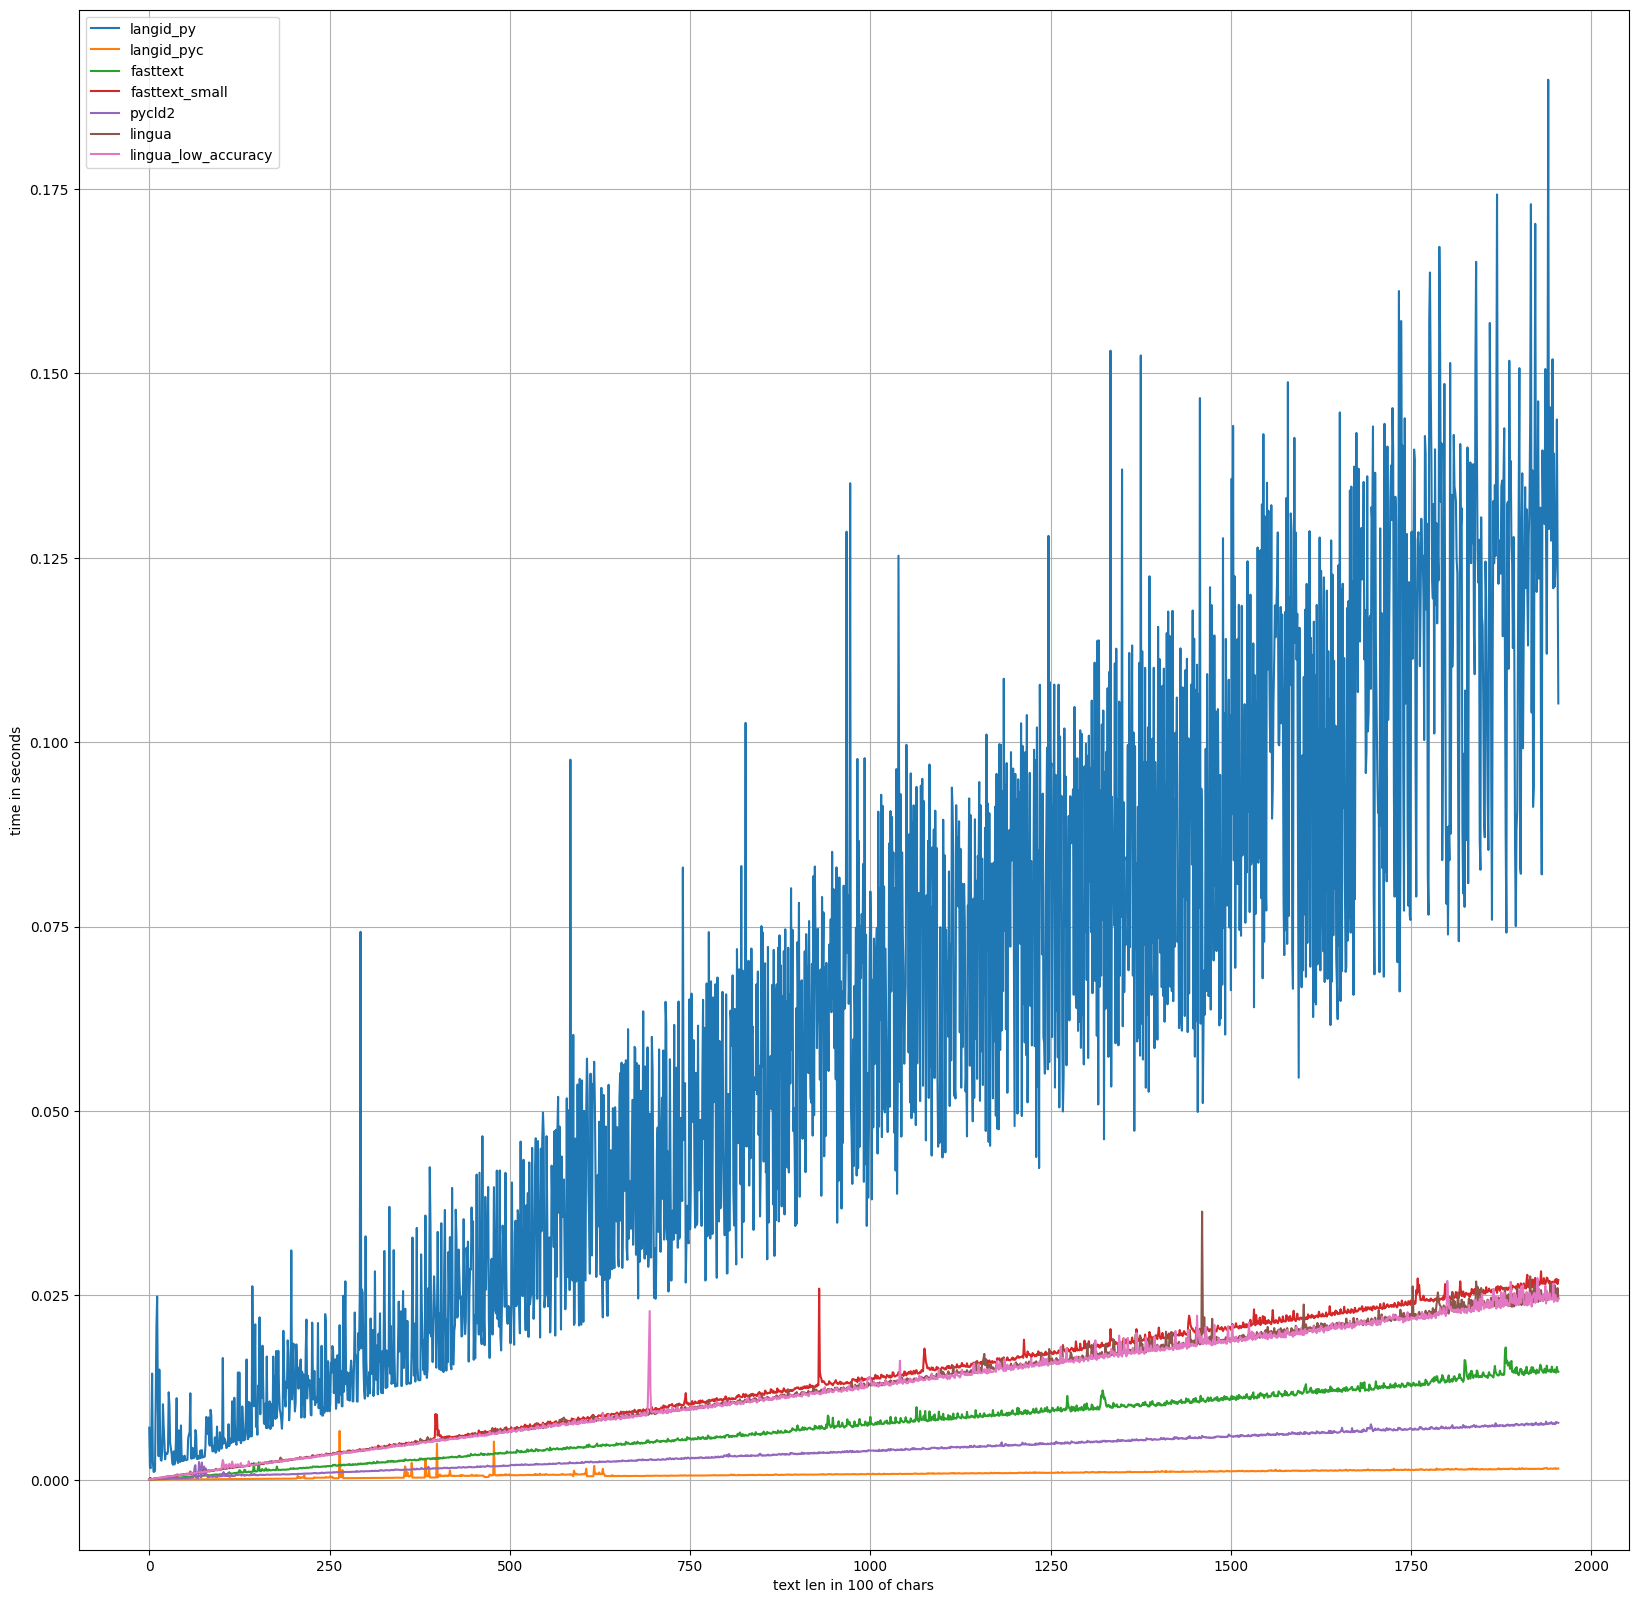

In [289]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(20, 20))

for identifier in Identifier:
    ax.plot(identifier_to_times[identifier], label=identifier.value)
    
ax.legend()
ax.grid()
ax.set_xlabel("text len in 100 of chars")
ax.set_ylabel("time in seconds")
plt.plot()

[]

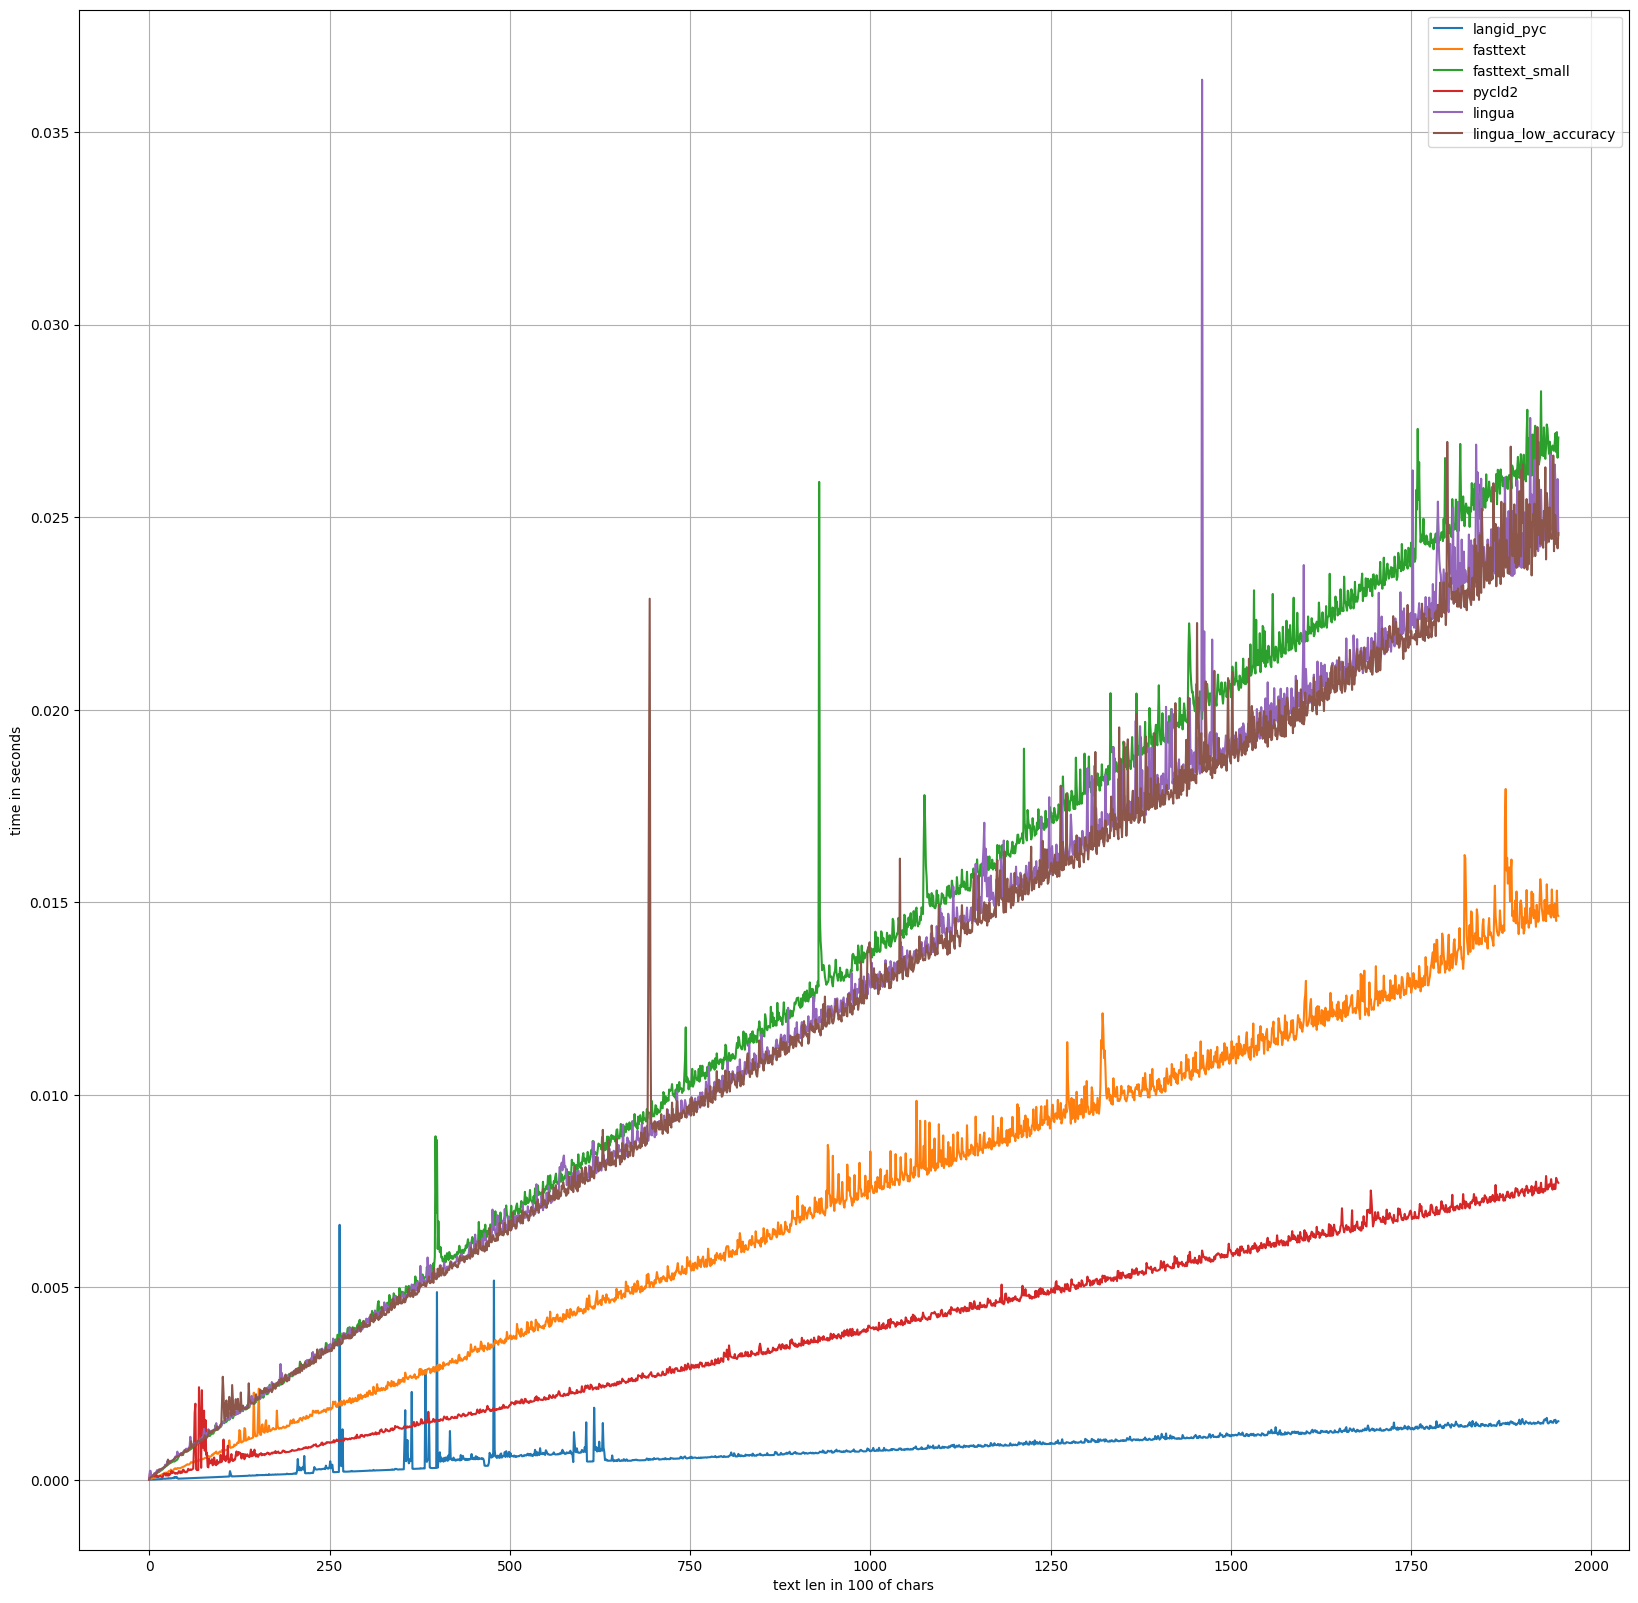

In [295]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(20, 20))

for identifier in Identifier:
    if identifier == Identifier.LANGID_PY:
        continue
    ax.plot(identifier_to_times[identifier], label=identifier.value)
    
ax.legend()
ax.grid()
ax.set_xlabel("text len in 100 of chars")
ax.set_ylabel("time in seconds")
plt.plot()

[]

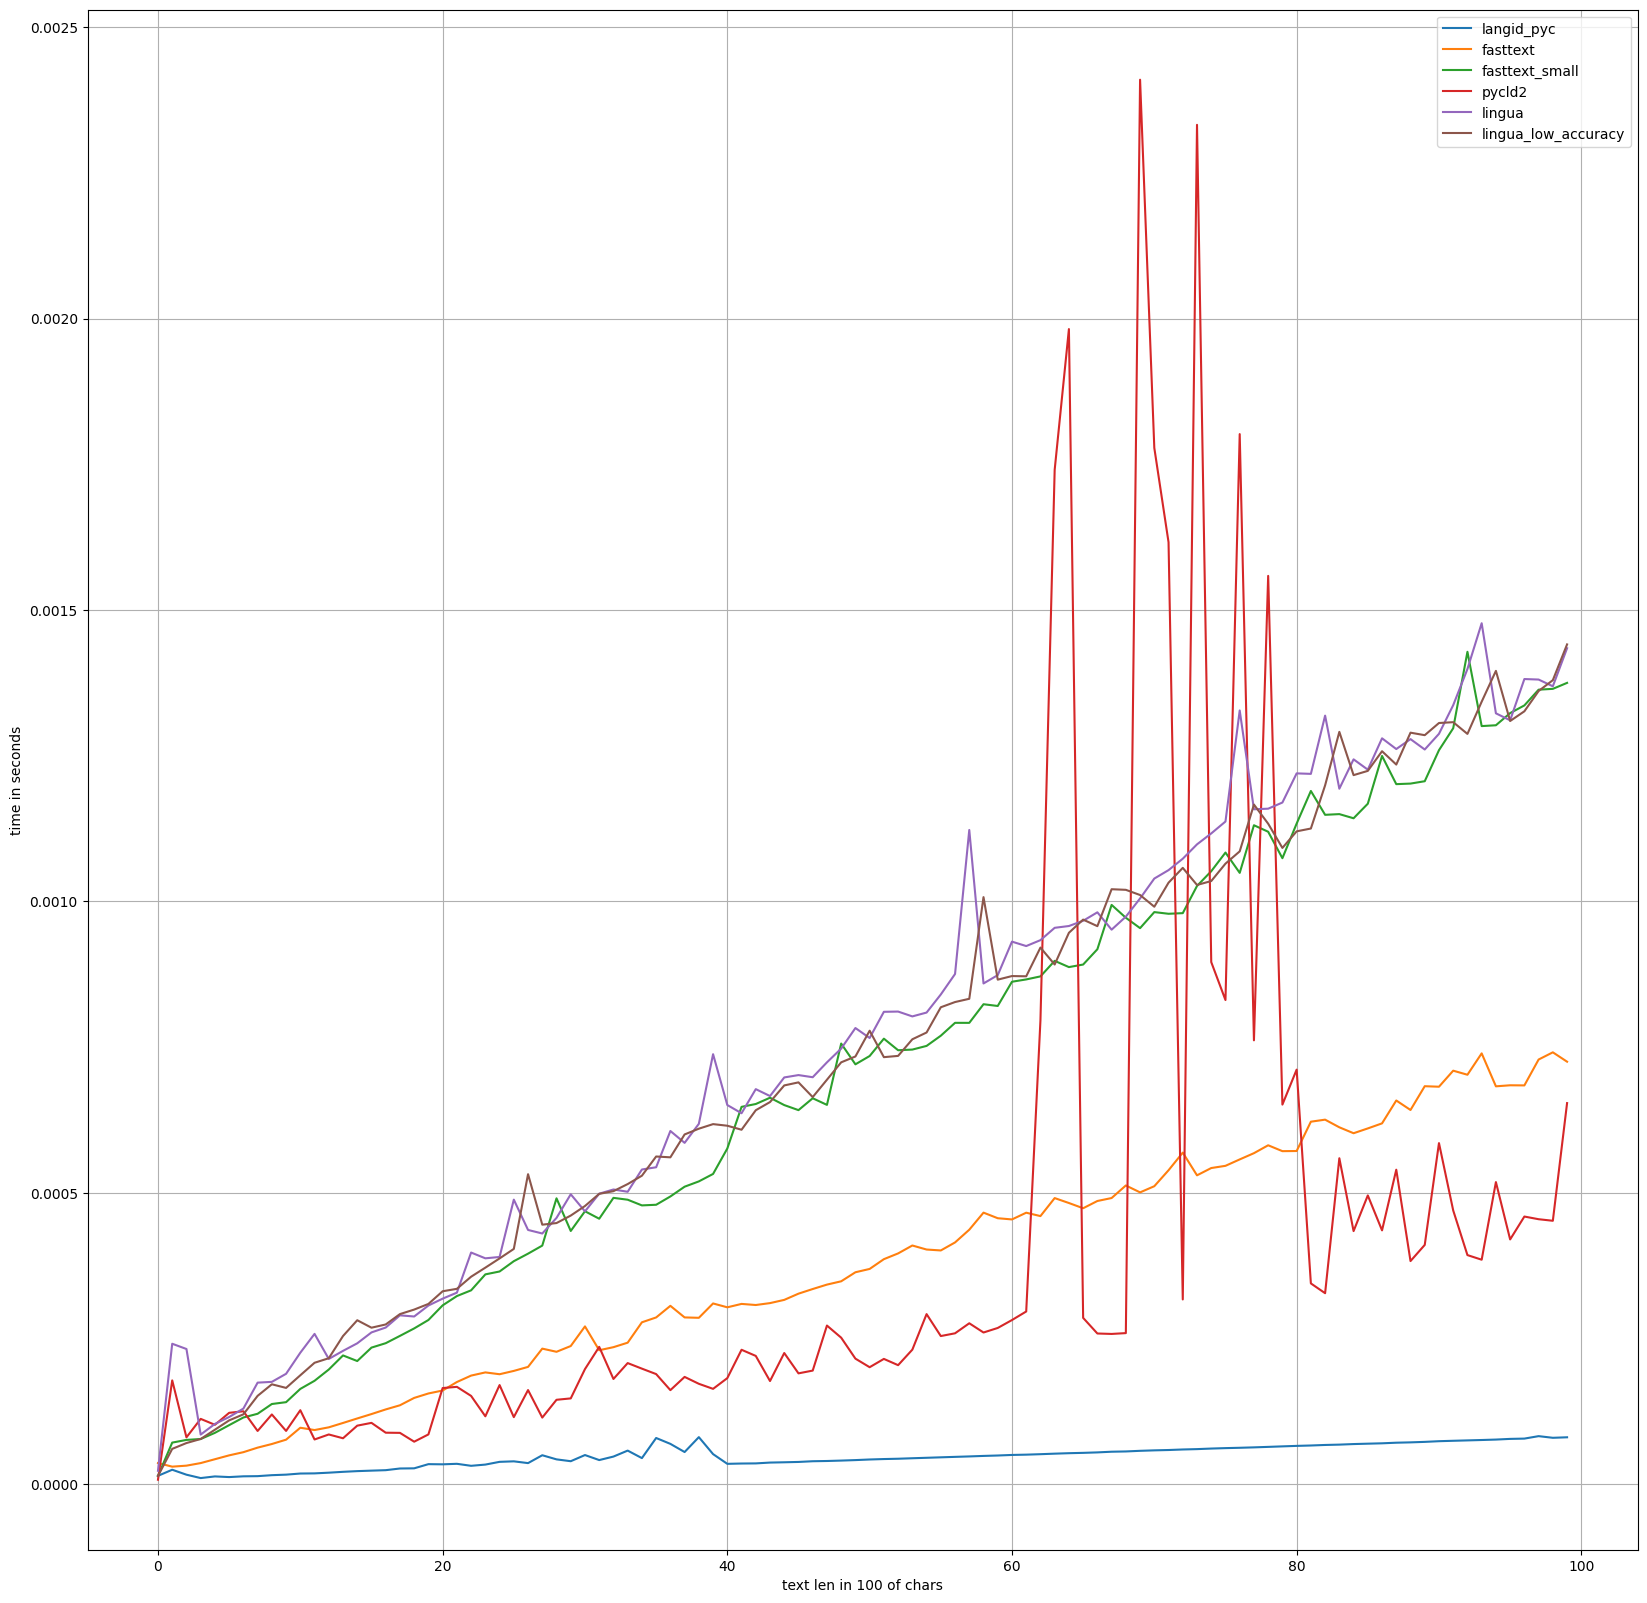

In [312]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(20, 20))

for identifier in Identifier:
    if identifier == Identifier.LANGID_PY:
        continue
    ax.plot(identifier_to_times[identifier][:100], label=identifier.value)
    
ax.legend()
ax.grid()
ax.set_xlabel("text len in 100 of chars")
ax.set_ylabel("time in seconds")
plt.plot()

We see that `langid_pyc`'s time increases with much slower than others